In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# alsgyu/sentiment-analysis-fine-tuned-model (긍정, 부정, 중립 분류모델)


In [ ]:
model_name = "alsgyu/sentiment-analysis-fine-tuned-model"

In [ ]:
# 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/722k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# 모델 불러오기
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# 파이프라인
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

Device set to use cuda:0


In [ ]:
text=" 사람이 없는편은 아니었는데"

In [ ]:
result = sentiment_analyzer(text)
print(result)

# 0- 부정
# 1- 중립
# 2- 긍정

[{'label': 'LABEL_1', 'score': 0.7977821826934814}]


# 데이터 불러오기

In [ ]:
import pandas as pd

# DataFrame으로 불러오기
df = pd.read_excel('C:\Users\r2com\Desktop\AI-STARS\labeled\AnotherLevel.xlsx')

# 불러온 데이터 확인
print(df.head())

                                             content
0  시립미술관, 강명희작가 "Visitors "전시회 유익하고 좋았습니다. (2/2) ...
1  덕수궁과 정동길을 거닐면서 언젠가는 가리라 했던 곳을 오늘에야 지인과 함께 서울시립...
2  시립미술관, 강명희작가 "Visitors "전시회 유익하고 좋았습니다. (1/2) ...
3  서울 무료로 멋진 작품들을 만나볼 수 있는 복합 문화 예술 공간 서울시립미술관. 전...
4        시립미술관 본관 전시 작품관람 전후 야외전시장 조각 작품 보며 휴식하기 좋아요


# 문장을 접속어로 분리

In [ ]:
!pip install kiwi -q
!pip install kiwipiepy -q

In [ ]:
from kiwipiepy import Kiwi

In [ ]:
kiwi = Kiwi()

In [ ]:
# 전환 접속어 패턴 정의
split_keywords = r"(지만|는데|더라도|고도|하긴 하지만|하긴하지만|하긴했지만|하긴 했지만|불구하고|그럼에도|반면에|대신에)"

In [ ]:
# 이모티콘/특수기호 제거 함수
def clean_text(text):
    # 이모지 제거
    text = re.sub(r'[^\w\s.,!?ㄱ-ㅎ가-힣]', '', text)
    # ㅋㅋ, ㅎㅎ 제거
    text = re.sub(r'[ㅋㅎㅠㅜ]{2,}', '', text)
    # 반복되는 특수기호 제거 (예: !!!, ~~)
    text = re.sub(r'[~!@#\$%\^&\*\(\)_\+=\[\]{}|\\:;"\'<>,.?/]{2,}', '', text)
    return text.strip()

In [ ]:
# 문장 분할
import re

for idx in range(23,28):
    text = df['content'][idx]
    print(f"\n 리뷰 {idx+1}")

    # 1차 문장 분리
    sentences = kiwi.split_into_sents(text)

    for i, s in enumerate(sentences):
        base = s.text.strip()

        # 2차 절 분리
        sub_clauses = re.split(split_keywords, base)

        # 접속어도 포함해서 재조합
        full_clauses = []
        for j in range(0, len(sub_clauses), 2):
            clause = sub_clauses[j].strip()
            if j+1 < len(sub_clauses):
                clause += sub_clauses[j+1]
            if clause:
                cleaned = clean_text(clause)
                if cleaned:  # 공백이 아니면
                    full_clauses.append(cleaned)

        # 출력
        for c in full_clauses:
            print(f"  {c}")

# 긍부중 저장

In [ ]:
import re
import pandas as pd

results = []

for idx in range(0, 100):
    text = df['content'][idx]

    # 1차 문장 분리
    sentences = kiwi.split_into_sents(text)

    for s in sentences:
        base = s.text.strip()

        # 2차 절 분리
        sub_clauses = re.split(split_keywords, base)

        # 접속어도 포함해서 재조합
        full_clauses = []
        for j in range(0, len(sub_clauses), 2):
            clause = sub_clauses[j].strip()
            if j + 1 < len(sub_clauses):
                clause += sub_clauses[j + 1]
            if clause:
                cleaned = clean_text(clause)
                if cleaned:
                    full_clauses.append(cleaned)

        # 절 단위로 classifier 돌리기
        for c in full_clauses:
            preds = sentiment_analyzer(c)
            label = preds[0]['label']
            score = preds[0]['score']
            results.append({
                'text': c,
                'label': label,
                'score': round(score, 4)
            })

# DataFrame으로 변환
result_df = pd.DataFrame(results)

In [ ]:
# Excel로 저장
save_path = '/content/drive/MyDrive/sentry/SeoulArtGallery.xlsx'

result_df.to_excel(save_path, index=False)

print("엑셀 저장 완료")

✅ 엑셀 저장 완료


# confidence score 시각화

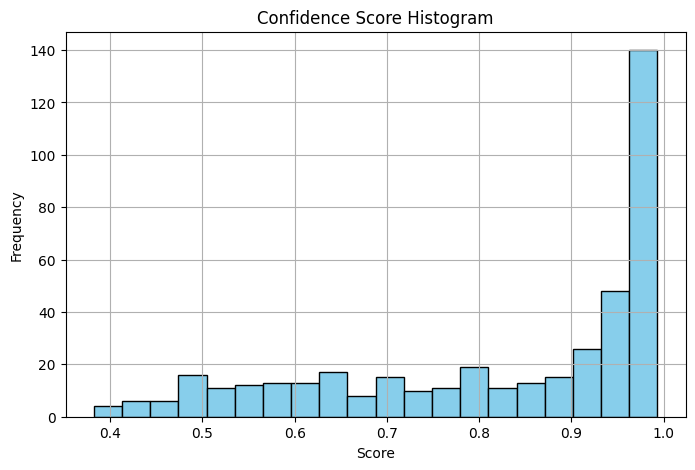

In [ ]:
import matplotlib.pyplot as plt

# 히스토그램 그리기
plt.figure(figsize=(8, 5))
plt.hist(result_df['score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Confidence Score Histogram')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()